In [17]:
import numpy as np
import qnm_filter
import qnm
import random
import argparse
from scipy.special import logsumexp
from pathlib import Path
import glob
import matplotlib.pyplot as pl
from gwpy.timeseries import TimeSeries

# Determine the modes to calculate the threshold for
modes_inj = ["220"] #The injected modes

duration = 4
fsamp = 4096

In [99]:
def signal_creator(noise_scale, amp_scale=1):
    global signal, signal_inj, mass, t_range, signalH_noise, mass_in_solar, chi_inject
    # Remnant properties
    mass_in_solar = 50 #random.uniform(10, 120)
    chi_inject = 0.5 #random.uniform(0.0, 0.95)
    injected = (mass_in_solar, chi_inject)
    mass = qnm_filter.Filter.mass_unit(injected[0]) #unit of time
    
    # Complex frequency of the modes
    omega_dict = {}
    for mode in modes_inj:
    	omega_dict[mode] = qnm.modes_cache(s=-2,l=int(mode[0]),m=int(mode[1]),n=int(mode[2]))(a=injected[1])[0]

    ref_amp = 8.4 * 1e-21
    t_range = np.arange(-duration/2, duration/2, 1/fsamp)
    
    # Creating the signal
    signal_inj = np.zeros(len(t_range))
    for keys, omega in omega_dict.items():
        phase = random.uniform(0, 2*np.pi)
        amp = ref_amp * amp_scale #random.uniform(0.7, 1.3)
        temp_signal = np.real(amp * np.exp(1j*phase) * np.exp(-1j * omega * np.abs(t_range / mass)))
        signal_inj = np.add(signal_inj, temp_signal)
    
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo(
    "H1", fsamp, duration, start_time=-duration / 2)
    signalH_noise = noise_scale*qnm_filter.bilby_get_strain(bilby_ifo, 0.0)
    signal = signal_inj + signalH_noise

In [100]:
def compute_SNR():
    fit = qnm_filter.Network(segment_length=0.2, srate=4096, t_init=3.0*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(signalH_noise, index=t_range)
    fit.condition_data('original_data', trim=False, remove_mean=False)
    fit.condition_data('pure_noise', trim=False, remove_mean=False)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    model_list_inj = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_inj]
        
    fit.pure_nr = {}
    fit.pure_nr["H1"] = qnm_filter.RealData(signal_inj, index=t_range, ifo="H1")
    fit.condition_data('pure_nr', trim=False, remove_mean=False)
    SNRtot_MF = fit.compute_SNR(
        fit.truncate_data(fit.original_data)["H1"],
        fit.truncate_data(fit.pure_nr)["H1"],
        "H1",
        False,
    )
    return np.array([SNRtot_MF])

In [103]:
SNR_arr = []
noise_scale = np.power(np.linspace(0.1, 1, 20), 1)
for i in noise_scale:
    signal_creator(1, i)
    SNR_arr.append(compute_SNR())

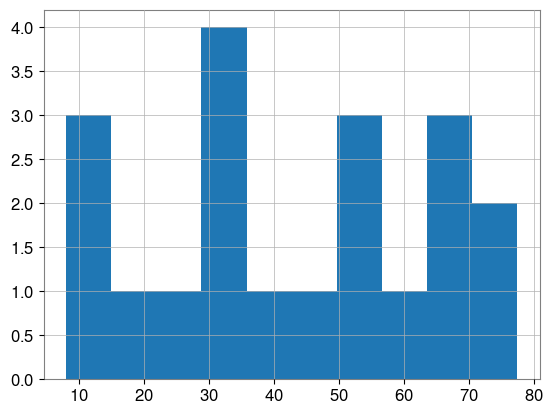

In [104]:
pl.hist(SNR_arr);

## Debugging

In [112]:
bilby_ifo = qnm_filter.set_bilby_predefined_ifo(
"H1", fsamp, duration, start_time=-duration / 2)
signalH_noise = qnm_filter.bilby_get_strain(bilby_ifo, 0.0)

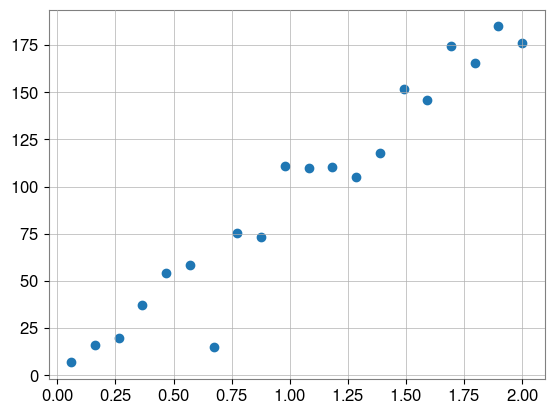

In [154]:
for i in np.linspace(0.06, 2, 20):
    mass_in_solar = random.uniform(10, 120)
    chi_inject = random.uniform(0.0, 0.95)
    injected = (mass_in_solar, chi_inject)
    mass = qnm_filter.Filter.mass_unit(injected[0]) #unit of time

    # Complex frequency of the modes
    omega_dict = {}
    for mode in modes_inj:
        omega_dict[mode] = qnm.modes_cache(s=-2,l=int(mode[0]),m=int(mode[1]),n=int(mode[2]))(a=injected[1])[0]

    ref_amp = 8.4e-21
    t_range = np.arange(-duration/2, duration/2, 1/fsamp)

    # Creating the signal
    signal_inj = np.zeros(len(t_range))
    for keys, omega in omega_dict.items():
        phase = random.uniform(0, 2*np.pi)
        amp = ref_amp * i #random.uniform(0.7, 1.3)
        temp_signal = np.real(amp * np.exp(1j*phase) * np.exp(-1j * omega * np.abs(t_range / mass)))
        signal_inj = np.add(signal_inj, temp_signal)

    signal = signal_inj + signalH_noise
    
    fit = qnm_filter.Network(segment_length=0.2, srate=4096, t_init=3.0*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(signalH_noise, index=t_range)
    fit.condition_data('original_data', trim=False, remove_mean=False)
    fit.condition_data('pure_noise', trim=False, remove_mean=False)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    model_list_inj = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_inj]

    fit.pure_nr = {}
    fit.pure_nr["H1"] = qnm_filter.RealData(signal_inj, index=t_range, ifo="H1")
    fit.condition_data('pure_nr', trim=False, remove_mean=False)
    SNRtot_MF = fit.compute_SNR(
        fit.truncate_data(fit.original_data)["H1"],
        fit.truncate_data(fit.pure_nr)["H1"],
        "H1",
        False,
    )
    pl.plot(i, SNRtot_MF, 'o', c='tab:blue')